<img src="NotebookAddons/blackboard-banner.jpg" width="100%" />
<font face="Calibri">
<br>
<font size="7"> <b> GEOS 657: Microwave Remote Sensing<b> </font>

<font size="5"> <b>Lab 4B: Exploring SAR Data and SAR Time Series Analysis using Jupyter Notebooks </b> </font>

<br>
<font size="4"> <b> Franz J Meyer; University of Alaska Fairbanks & Josef Kellndorfer, <a href="http://earthbigdata.com/" target="_blank">Earth Big Data, LLC</a> </b> <br>
<img src="NotebookAddons/UAFLogo_A_647.png" width="170" align="right" />
</font>

<font size="3"> This Lab is part of the UAF course <a href="https://radar.community.uaf.edu/" target="_blank">GEOS 657: Microwave Remote Sensing</a>. It introduces you to the analysis of deep multi-temporal SAR image data stacks in the framework of *Jupyter Notebooks*. The Jupyter Notebook environment is easy to launch in any web browser for interactive data exploration with provided or new training data. Notebooks are comprised of text written in a combination of executable python code and markdown formatting including latex style mathematical equations. Another advantage of Jupyter Notebooks is that they can easily be expanded, changed, and shared with new data sets or newly available time series steps. Therefore, they provide an excellent basis for collaborative and repeatable data analysis. <br>

<b>In this chapter we introduce the following data analysis concepts:</b>

- How to load your own SAR data into Jupyter Notebooks and create a time series stack 
- How to apply calibration constants to covert initial digital number (DN) data into calibrated radar cross section information.
- How to subset images and create a time series of your subset data.
- How to explore the time-series information in SAR data stacks for environmental analysis.


This Notebook is an addon to Lab 4 and doesn't include any homework assignments. Free free to play around with your own data and contact me at fjmeyer@alaska.edu should you run into any problems.
</font>

<hr>
<font face="Calibri" size="5" color="red"> <b>Important Note about JupyterHub</b> </font>
<br><br>
<font face="Calibri" size="3"> <b>Your JupyterHub server will automatically shutdown when left idle for more than 1 hour. Your notebooks will not be lost but you will have to restart their kernels and re-run them from the beginning. You will not be able to seamlessly continue running a partially run notebook.</b> </font>


<hr>
<font face="Calibri">

<font size="5"> <b> 0. Importing Relevant Python Packages </b> </font>

<font size="3">In this notebook we will use the following scientific libraries:
<ol type="1">
    <li> <b><a href="https://pandas.pydata.org/" target="_blank">Pandas</a></b> is a Python library that provides high-level data structures and a vast variety of tools for analysis. The great feature of this package is the ability to translate rather complex operations with data into one or two commands. Pandas contains many built-in methods for filtering and combining data, as well as the time-series functionality. </li>
    <li> <b><a href="https://www.gdal.org/" target="_blank">GDAL</a></b> is a software library for reading and writing raster and vector geospatial data formats. It includes a collection of programs tailored for geospatial data processing. Most modern GIS systems (such as ArcGIS or QGIS) use GDAL in the background.</li>
    <li> <b><a href="http://www.numpy.org/" target="_blank">NumPy</a></b> is one of the principal packages for scientific applications of Python. It is intended for processing large multidimensional arrays and matrices, and an extensive collection of high-level mathematical functions and implemented methods makes it possible to perform various operations with these objects. </li>
    <li> <b><a href="https://matplotlib.org/index.html" target="_blank">Matplotlib</a></b> is a low-level library for creating two-dimensional diagrams and graphs. With its help, you can build diverse charts, from histograms and scatterplots to non-Cartesian coordinates graphs. Moreover, many popular plotting libraries are designed to work in conjunction with matplotlib. </li>
    <li> The <b><a href="https://www.pydoc.io/pypi/asf-hyp3-1.1.1/index.html" target="_blank">asf-hyp3 API</a></b> provides useful functions and scripts for accessing and processing SAR data via the Alaska Satellite Facility's Hybrid Pluggable Processing Pipeline, or HyP3 (pronounced "hype"). </li>
<li><b><a href="https://www.scipy.org/about.html" target="_blank">SciPY</a></b> is a library that provides functions for numerical integration, interpolation, optimization, linear algebra and statistics. </li>

</font>

<font face="Calibri" size="3"> Our first step is to <b>import them:</b> </font>

In [1]:
# Scientific Libraries and hyp3 API
import pandas as pd # for DatetimeIndex
import gdal # for gdalbuildvr, gdalmerge, gdalwarp, gdal_translate, Open
from osgeo import gdal # for Info
import numpy as np # for copy, isnan, log10, ma.masked_where, max, mean, min, percentile, power, unique, var, where 
import matplotlib.pylab as plb # for figure, grid, rcParams, savefig
import matplotlib.pyplot as plt
from asf_hyp3 import API # for get_products, get_subscriptions, login
import scipy # for signal.savgol_filter()
import scipy.signal

from IPython.display import HTML

from asf_notebook import path_exists
from asf_notebook import pick_hyp3_subscription
from asf_notebook import get_hyp3_subscriptions
from asf_notebook import download_hyp3_products_v2
from asf_notebook import new_directory


#import matplotlib.animation
from matplotlib import animation
import matplotlib.patches as patches  # for Rectangle
from matplotlib import rc
import numpy as np

# General Purpose Libraries
import os # for chdir, getcwd, path.exists
import glob # for glob
import re # for match
from getpass import getpass # used to input URS creds and add to .netrc
import json # for loads

<font face="Calibri" size="3"><b>set up matplotlib plotting</b> inside the notebook:</font>

In [2]:
%matplotlib inline 

<hr>
<font face="Calibri">

<font size="5"> <b> 1. Load Your Own Data Stack Into the Notebook </b> </font> 

<font size="3"> This lab assumes that you've created your own data stack over your personal area of interest using the <a href="https://www.asf.alaska.edu/" target="_blank">Alaska Satellite Facility's</a> value-added product system <a href="http://hyp3.asf.alaska.edu/" target="_blank">HyP3</a>. HyP3 is an environment that is used by ASF to prototype value added products and provide them to users to collect feedback. 

This lab expects <a href="https://media.asf.alaska.edu/uploads/RTC/rtc_atbd_v1.2_final.pdf" target="_blank">Radiometric Terrain Corrected</a> (RTC) image products as input, so be sure to select an RTC process when creating the subscription for your input data within HyP. Prefer a **unique orbit geometry** (ascending or descending) to keep geometric differences between images low. 

We will retrieve HyP3 data via the HyP3 API. As both HyP3 and the Notebook environment sit in the <a href="https://aws.amazon.com/" target="_blank">Amazon Web Services (AWS)</a> cloud, data transfer is quick and cost effective.</font> 
</font>

<hr>
<font face="Calibri" size="3"> To download data from ASF, you need to provide your <a href="https://www.asf.alaska.edu/get-data/get-started/free-earthdata-account/" target="_blank">NASA Earth Data</a> username to the system. Setup an EarthData account if you do not yet have one. <font color='rgba(200,0,0,0.2)'><b>Note that EarthData's ULA applies when accessing the Hyp3 API from this notebook.</b></font>
<br><br>
<b>Store your NASA Earth Data <font color='rgba(200,0,0,0.2)'>username and password</font> in this notebook for later use in data downloading:</b> </font>

In [3]:
NASA_earthdata_username = "aflewandowski" #replace the current username with your own
NASA_earthdata_password = getpass()

filename="/home/jovyan/.netrc"
with open(filename, 'w+') as f:
    f.write(f"machine urs.earthdata.nasa.gov login {NASA_earthdata_username} password {NASA_earthdata_password}\n")

········


<hr>
<font face="Calibri" size="3"> Before we download anything, let's <b>first create a working directory for this analysis and change into it:</b> </font>

In [4]:
path = "/home/jovyan/notebooks/ASF/GEOS_657_Labs/lab_4B_data"
new_directory(path)
os.chdir(path)
print(f"Current working directory: {os.getcwd()}")

Created: /home/jovyan/notebooks/ASF/GEOS_657_Labs/lab_4B_data
Current working directory: /home/jovyan/notebooks/ASF/GEOS_657_Labs/lab_4B_data


<hr>
<font face="Calibri" size="3"> With your username/password now in place, you can now <b>log into the HyP3 API</b> (Documentation <a href="https://www.pydoc.io/pypi/asf-hyp3-1.1.1/index.html" target="_blank">here</a>):</font>

In [5]:
hyp3_api = API(NASA_earthdata_username)
hyp3_api.login(NASA_earthdata_password)


 login successful!


<font face="Calibri" size="3"><b>Create a folder in which to download your RTC products.</b> </font>

In [6]:
new_directory("rtc_products")
products_path = f"{path}/rtc_products"

Created: rtc_products


<font face="Calibri" size="3"><b>Download the products associated with an existing RTC subscription.</b> </font>

In [7]:
subscription_id = download_hyp3_products_v2(hyp3_api, products_path, 15)

Enter a subscription ID number:

Subscription id: 1661 Sierra_Negra_RTC_GAMMA

Subscription id: 1660 Nile_Delta_RTC_GAMMA

Subscription id: 1643 MedicineLake_RTC_S1TBX

Subscription id: 1641 MedicineLake_RTC_GAMMA

Subscription id: 1663 Sierra_Negra_InSAR_GAMMA

Subscription id: 1658 Ted_Stevens_Airport_2018_Earthquake_RTC_GAMMA

Subscription id: 1662 Sierra_Negra_RTC_S1TBX
1641

91 product/s associated with Subscription ID: 1641


S1B_IW_GRDH_1SDV_20190101T032019_20190101T032044_014295_01A97B_C882-POEORB-30m-power-rtc-gamma is not present.
[==================================================] 94908466.0 bps, 100%    

Extracting: /home/jovyan/notebooks/ASF/GEOS_657_Labs/lab_4B_data/rtc_products/S1B_IW_GRDH_1SDV_20190101T032019_20190101T032044_014295_01A97B_C882-POEORB-30m-power-rtc-gamma.zip

Done.

S1B_IW_GRDH_1SDV_20190220T030359_20190220T030424_015024_01C125_8554-POEORB-30m-power-rtc-gamma is not present.
[==================================================] 98712850.0 bps, 100%    


[==================================================] 96586705.0 bps, 100%    

Extracting: /home/jovyan/notebooks/ASF/GEOS_657_Labs/lab_4B_data/rtc_products/S1A_IW_GRDH_1SDV_20190204T161143_20190204T161208_025782_02DE0A_26E1-POEORB-30m-power-rtc-gamma.zip

Done.


<hr>
<font face="Calibri" size="3"><b>Determine the subscription's process type</b>, which we need in order to determine the file paths to the VV tiffs.</font>

In [8]:
subscription_info = hyp3_api.get_subscription(subscription_id)
process_type = subscription_info['process_id']

<font face="Calibri" size="3"><b>Create a variable called <i>paths</i>, that holds the paths to the VVs</b>, which varies based on process type:</font>

In [9]:
rtc_path = "rtc_products"
if path_exists(products_path):
    if process_type == 2: #GAMMA
        paths = f"{rtc_path}/*/*_VV.tif"   
    elif process_type == 18: #S1TBX
        paths = f"{rtc_path}/*/*-VV.tif" 
    else:
        print("This recipe requires RTC imagery.\nMake sure your Hyp subscription uses either RTC-GAMMA or RTC-S1TBX processes.")   

<font face="Calibri" size="3"><b>Create a list containing the product acquisition dates:</b></font>

In [10]:
if paths:
        dates = []
        pth = glob.glob(paths)
        pth.sort()
        for p in pth:
            date = (p.split("_")[5])[0:8]
            dates.append(date)
            print(date)

20180422
20180504
20180609
20180820
20190204
20180223
20180319
20180412
20180705
20181009
20181021
20181102
20190101
20190220
20190501


<hr>
<font face="Calibri" size="3"> You may notice duplicates in your acquisition dates. As HyP3 processes SAR data on a frame-by-frame basis, duplicates may occur if your area of interest is covered by two consecutive  image frames. In this case, two separate images are generated that need to be merged together before time series processing can commence. 
<br><br>
<b>Write functions to collect and print the paths of the VV tiffs:</b> </font>

In [11]:
def get_tiff_paths(paths):
    tiff_paths = !ls $paths | sort -t_ -k5,5
    return tiff_paths

def print_tiff_paths(tiff_paths):
    print("Tiff paths:")
    for p in tiff_paths:
        print(f"{p}\n")

<font face="Calibri" size="3"><b>Collect and print the paths of the VV tiffs:</b></font>

In [12]:
tiff_paths = get_tiff_paths(paths)
print_tiff_paths(tiff_paths)

Tiff paths:
rtc_products/S1A_IW_GRDH_1SDV_20180422T161137_20180422T161202_021582_025323_20D8-POEORB-30m-power-rtc-gamma/S1A_IW_RT30_20180422T161137_G_gpn_VV.tif

rtc_products/S1A_IW_GRDH_1SDV_20180504T161138_20180504T161203_021757_0258AB_5604-POEORB-30m-power-rtc-gamma/S1A_IW_RT30_20180504T161138_G_gpn_VV.tif

rtc_products/S1A_IW_GRDH_1SDV_20180609T161140_20180609T161205_022282_02694F_B950-POEORB-30m-power-rtc-gamma/S1A_IW_RT30_20180609T161140_G_gpn_VV.tif

rtc_products/S1A_IW_GRDH_1SDV_20180820T161144_20180820T161209_023332_0289AD_33F5-POEORB-30m-power-rtc-gamma/S1A_IW_RT30_20180820T161144_G_gpn_VV.tif

rtc_products/S1A_IW_GRDH_1SDV_20190204T161143_20190204T161208_025782_02DE0A_26E1-POEORB-30m-power-rtc-gamma/S1A_IW_RT30_20190204T161143_G_gpn_VV.tif

rtc_products/S1B_IW_GRDH_1SDV_20180223T032011_20180223T032036_009745_011990_0B52-POEORB-30m-power-rtc-gamma/S1B_IW_RT30_20180223T032011_G_gpn_VV.tif

rtc_products/S1B_IW_GRDH_1SDV_20180319T032011_20180319T032036_010095_012522_4E39-POEORB-

<hr>
<font face="Calibri" size="3"> <b>Fix multiple UTM Zone-related issues</b> should they exist in your data set. If multiple UTM zones are found, the following code cells will identify the predominant UTM zone and reproject the rest into that zone. </font>
<br><br>
<font face="Calibri" size="3"><b>Use gdal.Info to determine the UTM definition types and zones in each product:</b></font>

In [13]:
utm_zones = []
utm_types = []
print('Checking UTM Zones in the data stack ...\n')
for k in range(0, len(tiff_paths)):
    info = (gdal.Info(tiff_paths[k], options = ['-json']))
    info = (json.loads(info))['coordinateSystem']['wkt']
    zone = info[(len(info)-8):(len(info)-3)]
    utm_zones.append(zone)
    typ = info[(len(info)-15):(len(info)-11)]
    utm_types.append(typ)
print(f"UTM Zones:\n {utm_zones}\n")
print(f"UTM Types:\n {utm_types}")

Checking UTM Zones in the data stack ...

UTM Zones:
 ['32606', '32606', '32606', '32606', '32606', '32606', '32606', '32606', '32606', '32606', '32606', '32606', '32606', '32607', '32606']

UTM Types:
 ['EPSG', 'EPSG', 'EPSG', 'EPSG', 'EPSG', 'EPSG', 'EPSG', 'EPSG', 'EPSG', 'EPSG', 'EPSG', 'EPSG', 'EPSG', 'EPSG', 'EPSG']


<font face="Calibri" size="3"><b>Identify the most commonly used UTM Zone in the data:</b></font>

In [14]:
utm_unique, counts = np.unique(utm_zones, return_counts=True)
a = np.where(counts == np.max(counts))
predominate_utm = utm_unique[a][0]
print(f"Predominate UTM Zone: {predominate_utm}")

Predominate UTM Zone: 32606


<font face="Calibri" size="3"><b>Reproject VVs with errant UTMs to the predominate UTM:</b></font>

In [15]:
reproject_indicies = [i for i, j in enumerate(utm_zones) if j != predominate_utm] #makes list of indicies in utm_zones that need to be reprojected
print('--------------------------------------------')
print('Reprojecting %4.1f files' %(len(reproject_indicies)))
print('--------------------------------------------')
for k in reproject_indicies:
    temppath = tiff_paths[k].strip()
    _, product_name, tiff_name = temppath.split('/')
    cmd = f"gdalwarp -overwrite rtc_products/{product_name}/{tiff_name} rtc_products/{product_name}/r{tiff_name} -s_srs {utm_types[k]}:{utm_zones[k]} -t_srs EPSG:{predominate_utm}"
    #print(f"Calling the command: {cmd}")
    !{cmd}
    rm_command = f"rm {tiff_paths[k].strip()}"
    #print(f"Calling the command: {rm_command}")
    !{rm_command}

--------------------------------------------
Reprojecting  1.0 files
--------------------------------------------
Creating output file that is 10100P x 7945L.
Processing rtc_products/S1B_IW_GRDH_1SDV_20190220T030359_20190220T030424_015024_01C125_8554-POEORB-30m-power-rtc-gamma/S1B_IW_RT30_20190220T030359_G_gpn_VV.tif [1/1] : 0Using internal nodata values (e.g. 0) for image rtc_products/S1B_IW_GRDH_1SDV_20190220T030359_20190220T030424_015024_01C125_8554-POEORB-30m-power-rtc-gamma/S1B_IW_RT30_20190220T030359_G_gpn_VV.tif.
Copying nodata values from source rtc_products/S1B_IW_GRDH_1SDV_20190220T030359_20190220T030424_015024_01C125_8554-POEORB-30m-power-rtc-gamma/S1B_IW_RT30_20190220T030359_G_gpn_VV.tif to destination rtc_products/S1B_IW_GRDH_1SDV_20190220T030359_20190220T030424_015024_01C125_8554-POEORB-30m-power-rtc-gamma/rS1B_IW_RT30_20190220T030359_G_gpn_VV.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


<hr>
<font face="Calibri" size="3"> <b>Concatenate neighboring image frames</b> should your area be covered by more than one frame. </font>

In [16]:
for  k in range(1, len(dates)):
    if dates[k] == dates[k-1]:
        print(k)
        temp = tiff_paths[k-1]
        _, product_name, tiff_name = temp.split('/')
        gdal_command = f"gdal_merge.py -o rtc_products/{product_name}/new-{tiff_name} {tiff_paths[k]} {tiff_paths[k-1]}"
        print(f"Calling the command: {gdal_command}")
        !{gdal_command}
        rm_command = f"rm {tiff_paths[k]}"
        print(f"Calling the command: {rm_command}")
        !{rm_command}
        rm_command = f"rm {tiff_paths[k-1]}"
        print(f"Calling the command: {rm_command}")
        !{rm_command}

<hr>
<font face="Calibri" size="3"> <b>Verify that all duplicate dates were resolved:</b> </font>

In [17]:
dates = []
pth = glob.glob(paths)
pth.sort()
for p in pth:
    date = (p.split("_")[5])[0:8]
    dates.append(date)
if len(dates) == len(set(dates)):
    print(f"Duplicate dates resolved.")
else:
    print(f"Duplicate dates still present!")


Duplicate dates resolved.


<hr>
<font face="Calibri">

<font size="5"> <b> 2. Create Subset and Stack Up Your Data </b> </font> 

<font size="3"> Now you are ready to work with your data. The next cells allow you to select an area of interest (AOI; via bounding-box corner coordinates) for your data analysis. Once selected, the AOI is being extracted and a data stack is formed.

<b>As a first step, we extract your AOI from the full frames:</b>
</font> 
</font>

In [18]:
# Using Google Maps, get the rough bounding box for the subset
# Enter your corner coordinates below
upper_left_x = -144.58
lower_right_x = -144.48
lower_right_y = 65.48
upper_left_y = 65.53
print(f"upper left x coord: {upper_left_x}\nupper left y coord: {upper_left_y}\nlower right x coord: {lower_right_x}\nlower right y coord: {lower_right_y}")

upper left x coord: -144.58
upper left y coord: 65.53
lower right x coord: -144.48
lower right y coord: 65.48


<font size="3"> <b>Update the list of all the absolute paths of the VV tiffs:</b> </font> 

In [19]:
tiff_paths = get_tiff_paths(paths)
print_tiff_paths(tiff_paths)

Tiff paths:
rtc_products/S1A_IW_GRDH_1SDV_20180422T161137_20180422T161202_021582_025323_20D8-POEORB-30m-power-rtc-gamma/S1A_IW_RT30_20180422T161137_G_gpn_VV.tif

rtc_products/S1A_IW_GRDH_1SDV_20180504T161138_20180504T161203_021757_0258AB_5604-POEORB-30m-power-rtc-gamma/S1A_IW_RT30_20180504T161138_G_gpn_VV.tif

rtc_products/S1A_IW_GRDH_1SDV_20180609T161140_20180609T161205_022282_02694F_B950-POEORB-30m-power-rtc-gamma/S1A_IW_RT30_20180609T161140_G_gpn_VV.tif

rtc_products/S1A_IW_GRDH_1SDV_20180820T161144_20180820T161209_023332_0289AD_33F5-POEORB-30m-power-rtc-gamma/S1A_IW_RT30_20180820T161144_G_gpn_VV.tif

rtc_products/S1A_IW_GRDH_1SDV_20190204T161143_20190204T161208_025782_02DE0A_26E1-POEORB-30m-power-rtc-gamma/S1A_IW_RT30_20190204T161143_G_gpn_VV.tif

rtc_products/S1B_IW_GRDH_1SDV_20180223T032011_20180223T032036_009745_011990_0B52-POEORB-30m-power-rtc-gamma/S1B_IW_RT30_20180223T032011_G_gpn_VV.tif

rtc_products/S1B_IW_GRDH_1SDV_20180319T032011_20180319T032036_010095_012522_4E39-POEORB-

<font size="3"><b>Move the _VV.tiffs from the individual product directories into their own directory, /tiffs:</b>
</font> 

In [20]:
!mkdir -p tiffs
if path_exists('tiffs'):
    for tiff_path in tiff_paths:
        _, granule_name, tiff_name = tiff_path.split('/')
        g1, g2, g3, date, g4, g5, g6 = tiff_name.split('_')
       
        gdal_command = f"gdal_translate -projwin {upper_left_x} {upper_left_y} {lower_right_x} {lower_right_y} -projwin_srs 'WGS84' -co \"COMPRESS=DEFLATE\" -a_nodata 0 {tiff_path} tiffs/{date}_VV.tiff"
        
        print(f"Calling the command: {gdal_command}")
        !{gdal_command}

Calling the command: gdal_translate -projwin -144.58 65.53 -144.48 65.48 -projwin_srs 'WGS84' -co "COMPRESS=DEFLATE" -a_nodata 0 rtc_products/S1A_IW_GRDH_1SDV_20180422T161137_20180422T161202_021582_025323_20D8-POEORB-30m-power-rtc-gamma/S1A_IW_RT30_20180422T161137_G_gpn_VV.tif tiffs/20180422T161137_VV.tiff
Input file size is 9480, 7154
0...10...20...30...40...50...60...70...80...90...100 - done.
Calling the command: gdal_translate -projwin -144.58 65.53 -144.48 65.48 -projwin_srs 'WGS84' -co "COMPRESS=DEFLATE" -a_nodata 0 rtc_products/S1A_IW_GRDH_1SDV_20180504T161138_20180504T161203_021757_0258AB_5604-POEORB-30m-power-rtc-gamma/S1A_IW_RT30_20180504T161138_G_gpn_VV.tif tiffs/20180504T161138_VV.tiff
Input file size is 9480, 7152
0...10...20...30...40...50...60...70...80...90...100 - done.
Calling the command: gdal_translate -projwin -144.58 65.53 -144.48 65.48 -projwin_srs 'WGS84' -co "COMPRESS=DEFLATE" -a_nodata 0 rtc_products/S1A_IW_GRDH_1SDV_20180609T161140_20180609T161205_022282_0269

<font size="3"><b>Grab the updated paths of the VVs:</b></font>

In [21]:
tp = f"{path}/tiffs"
tiff_paths = get_tiff_paths(tp)
print_tiff_paths(tiff_paths)

Tiff paths:
20180223T032011_VV.tiff

20180319T032011_VV.tiff

20180412T032012_VV.tiff

20180422T161137_VV.tiff

20180504T161138_VV.tiff

20180609T161140_VV.tiff

20180705T032017_VV.tiff

20180820T161144_VV.tiff

20181009T032021_VV.tiff

20181021T032021_VV.tiff

20181102T032021_VV.tiff

20190101T032019_VV.tiff

20190204T161143_VV.tiff

20190220T030359_VV.tiff

20190501T032019_VV.tiff



<font size="3">In case you accidentaly created a subscription containing products with no data in your selected subset,<b> check the *_VV.tif files for nans as a maximum value and delete those files.</b> If you don't do this and there are images with no data, they will appear as black slides in your time-series animation.</font>

In [22]:
t_path = f"{path}/tiffs/"
for tiff in tiff_paths:
    raster = gdal.Open(f"{t_path}{tiff}")
    band = raster.ReadAsArray()
    
    if not np.amax(band):
        nan_path = f"{t_path}{tiff}"
        !rm $nan_path

In [23]:
'''
t_path = f"{path}/tiffs/"
for i in range (0, len(tiff_paths)):
    raster = gdal.Open(f"{t_path}{tiff_paths[i]}")
    band = raster.ReadAsArray()
    
    if not np.amax(band):
        nan_path = f"{t_path}{tiff_paths[i]}"
        !rm $nan_path
'''

'\nt_path = f"{path}/tiffs/"\nfor i in range (0, len(tiff_paths)):\n    raster = gdal.Open(f"{t_path}{tiff_paths[i]}")\n    band = raster.ReadAsArray()\n    \n    if not np.amax(band):\n        nan_path = f"{t_path}{tiff_paths[i]}"\n        !rm $nan_path\n'

<font size="3"><b>Update the list of dates after removing nans:</b></font>

In [24]:
dates = []
pth = glob.glob(f"{t_path}/*_VV.tiff")
pth.sort()
for p in pth:
    date = p[len(p)-23:len(p)-15]
    dates.append(date)
    print(date)

20180422
20180504
20180609
20180820
20190204
20190220


<hr>
<font face="Calibri" size="3"> Now we stack up the data by creating a virtual raster table with links to all subset data files: </font>
<br><br>
<font size="3"><b>Create the virtual raster table for the subset GeoTiffs:</b></font>

In [25]:
!gdalbuildvrt -separate rtc_products.vrt tiffs/*.tiff

0...10...20...30...40...50...60...70...80...90...100 - done.


<hr>
<font face="Calibri">

<font size="5"> <b> 3. Now You Can Work With Your Data </b> </font> 

<font size="3"> Now you are ready to perform time series analysis on your data stack
</font> 
</font>

<br>
<font face="Calibri" size="4"> <b> 3.1 Define Data Directory and Path to VRT </b> </font> 
<br><br>
<font face="Calibri" size="3"><b>Create a variable containing the VRT filename:</b></font>

In [26]:
image_file = "rtc_products.vrt"

<font face="Calibri" size="3"><b>Create an index of timedelta64 data with Pandas:</b></font>

In [27]:
tindex=pd.DatetimeIndex(dates)

<font face="Calibri" size="3"><b>Print the bands and dates for all images in the virtual raster table (VRT):</b></font>

In [28]:
j=1
print(f"Bands and dates for {image_file}")
for i in tindex:
    print("{:4d} {}".format(j, i.date()),end=' ')
    j+=1
    if j%5==1: print()

Bands and dates for rtc_products.vrt
   1 2018-04-22    2 2018-05-04    3 2018-06-09    4 2018-08-20    5 2019-02-04 
   6 2019-02-20 

<hr>
<br>
<font face="Calibri" size="4"> <b> 3.2 Open Your Data Stack and Visualize Some Layers </b> </font> 

<font face="Calibri" size="3"> We will <b>open your VRT</b> and visualize some layers using Matplotlib. </font>

In [29]:
img=gdal.Open(image_file)

<font face="Calibri" size="3"><b>Print the bands, pixels, and lines:</b></font>

In [30]:
print(f"Number of  bands: {img.RasterCount}")
print(f"Number of pixels: {img.RasterXSize}")
print(f"Number of  lines: {img.RasterYSize}")

Number of  bands: 6
Number of pixels: 161
Number of  lines: 180


<font face="Calibri" size="3"><b>Read in raster data for the first two bands:</b></font>

In [31]:
raster_1 = img.GetRasterBand(1).ReadAsArray() # change the number passed to GetRasterBand() to 
where_are_NaNs = np.isnan(raster_1)           # read rasters from different bands
raster_1[where_are_NaNs] = 0

raster_2 = img.GetRasterBand(2).ReadAsArray() #must pass a valid band number to GetRasterBand()
where_are_NaNs = np.isnan(raster_2)
raster_2[where_are_NaNs] = 0

<font face="Calibri" size="3"><b>Plot images and histograms for bands 1 and 2:</b></font>

Text(0.5, 1.0, 'Histogram Band 2 2018-05-04')

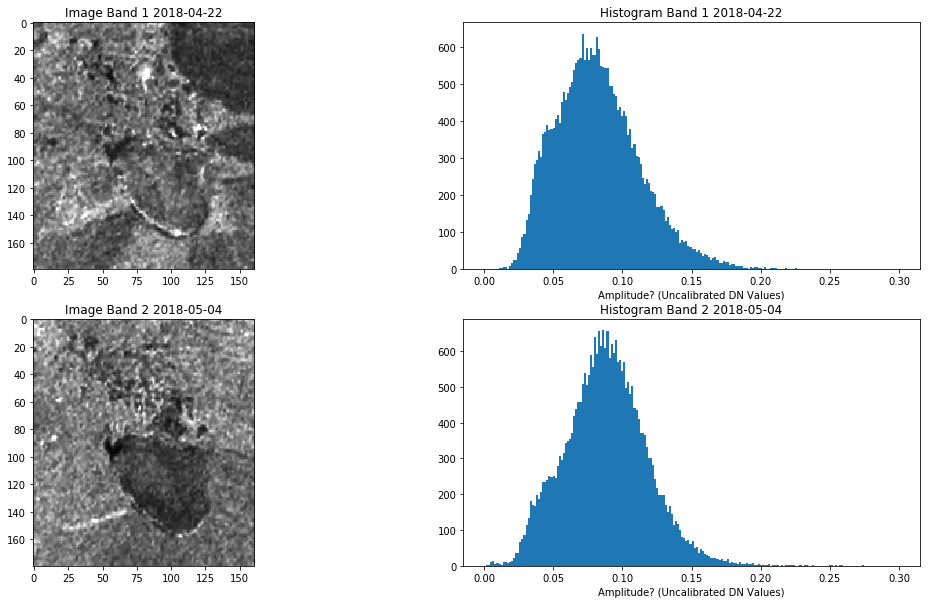

In [32]:
# Setup the pyplot plots
fig = plb.figure(figsize=(18,10)) # Initialize figure with a size
ax1 = fig.add_subplot(221)  # 221 determines: 2 rows, 2 plots, first plot
ax2 = fig.add_subplot(222)  # 222 determines: 2 rows, 2 plots, second plot
ax3 = fig.add_subplot(223)  # 223 determines: 2 rows, 2 plots, third plot
ax4 = fig.add_subplot(224)  # 224 determines: 2 rows, 2 plots, fourth plot

# Plot the band 1 image
band_number = 1
ax1.imshow(raster_1,cmap='gray', vmin=0, vmax=0.2) #,vmin=2000,vmax=10000)
ax1.set_title('Image Band {} {}'.format(band_number, tindex[band_number-1].date()))

# Flatten the band 1 image into a 1 dimensional vector and plot the histogram:
h = ax2.hist(raster_1.flatten(), bins=200, range=(0, 0.3))
ax2.xaxis.set_label_text('Amplitude? (Uncalibrated DN Values)')
ax2.set_title('Histogram Band {} {}'.format(band_number, tindex[band_number-1].date()))

# Plot the band 2 image
band_number = 2
ax3.imshow(raster_2,cmap='gray', vmin=0, vmax=0.2) #,vmin=2000,vmax=10000)
ax3.set_title('Image Band {} {}'.format(band_number, tindex[band_number-1].date()))

# Flatten the band 2 image into a 1 dimensional vector and plot the histogram:
h = ax4.hist(raster_2.flatten(),bins=200,range=(0,0.3))
ax4.xaxis.set_label_text('Amplitude? (Uncalibrated DN Values)')
ax4.set_title('Histogram Band {} {}'.format(band_number, tindex[band_number-1].date()))

<hr>
<br>
<font face="Calibri" size="4"> <b> 3.3 Calibration and Data Conversion between dB and Power Scales </b> </font>

<font face="Calibri" size="3"> <font color='rgba(200,0,0,0.2)'> <b>Note, that if your data were generated by HyP3, this step is not necessary!</b> HyP3 performs the full data calibration and provides you with calibrated data in power scale. </font>
    
If, your data is from a different source, however, calibration may be necessary to ensure that image gray values correspond to proper radar cross section information. 

Calibration coefficients for SAR data are often defined in the decibel (dB) scale due to the high dynamic range of the imaging system. For the L-band ALOS PALSAR data at hand, the conversion from uncalibrated DN values to calibrated radar cross section values in dB scale is performed by applying a standard **calibration factor of -83 dB**. 
<br> <br>
$\gamma^0_{dB} = 20 \cdot log10(DN) -83$

The data at hand are radiometrically terrain corrected images, which are often expressed as terrain flattened $\gamma^0$ backscattering coefficients. For forest and land cover monitoring applications $\gamma^o$ is the preferred metric.

<b>To apply the calibration constant for your data and export in *dB* scale, uncomment the following code cell</b>: </font> 

In [33]:
 #caldB=20*np.log10(rasterstack)-83

<font face="Calibri" size="3"> While **dB**-scaled images are often "visually pleasing", they are often not a good basis for mathematical operations on data. For instance, when we compute the mean of observations, it makes a difference whether we do that in power or dB scale. Since dB scale is a logarithmic scale, we cannot simply average data in that scale. 
    
Please note that the **correct scale** in which operations need to be performed **is the power scale.** This is critical, e.g. when speckle filters are applied, spatial operations like block averaging are performed, or time series are analyzed.

To **convert from dB to power**, apply: $\gamma^o_{pwr} = 10^{\frac{\gamma^o_{dB}}{10}}$ </font>

In [34]:
#calPwr=np.power(10.,caldB/10.)

<hr>
<br>
<font face="Calibri" size="4"> <b> 3.4 Create a Time Series Animation </b> </font>

<font face="Calibri" size="3"> Now we are ready to <b>create a time series animation</b> from the calibrated SAR data. </font> 

In [35]:
band = img.GetRasterBand(1)
raster0 = band.ReadAsArray()
band_number = 0 # Needed for updates
rasterstack = img.ReadAsArray()

In [36]:
rs2 = np.ma.masked_where(rasterstack==0, rasterstack)

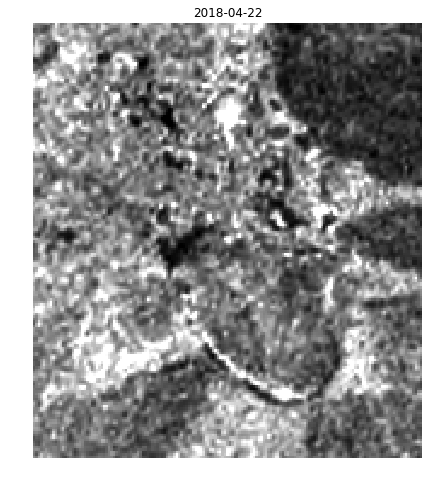

In [37]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)
ax.axis('off')
vmin = np.percentile(rasterstack.flatten(), 5)
vmax = np.percentile(rasterstack.flatten(), 95)

r0dB = 20 * np.log10(raster0) - 83

im = ax.imshow(raster0, cmap='gray', vmin=vmin, vmax=vmax)
ax.set_title("{}".format(tindex[0].date()))

def animate(i):
    ax.set_title("{}".format(tindex[i].date()))
    im.set_data(rasterstack[i])

# Interval is given in milliseconds
ani = animation.FuncAnimation(fig, animate, frames=rasterstack.shape[0], interval=400)

<font face="Calibri" size="3"><b>Configure matplotlib's RC settings for the animation:</b></font> 

In [38]:
rc('animation', embed_limit=40971520.0)  # We need to increase the limit maybe to show the entire animation

<font face="Calibri" size="3"><b>Create a javascript animation of the time-series running inline in the notebook:</b></font> 

In [39]:
HTML(ani.to_jshtml())

<font face="Calibri" size="3"><b>Delete the dummy png</b> that was saved to the current working directory while generating the javascript animation in the last code cell.</font> 

In [56]:
try:
    os.remove('None0000000.png')
except FileNotFoundError:
    pass

<font face="Calibri" size="3"><b>Save the animation as a gif:</b> </font> 

In [41]:
ani.save('animation.gif', writer='pillow', fps=2)

<br>
<hr>
<font face="Calibri" size="4"> <b> 3.5 Plot the Time Series of Means Calculated Across the Subset </b> </font>

<font face="Calibri" size="3"> To create the time series of means, we will go through the following steps:
1. Ensure that you use the data in **power scale** ($\gamma^o_{pwr}$) for your mean calculations.
2. compute means.
3. convert the resulting mean values into dB scale for visualization.
4. plot time series of means. </font> 

In [42]:
# 2. Compute Means 
rs_means_pwr = np.mean(rs2, axis=(1, 2))
print(rs_means_pwr)
# 3. Convert resulting mean value time-series to dB scale for visualization
rs_means_dB = 10.*np.log10(rs_means_pwr)
print(rs_means_dB)

[0.08264972 0.08799508 0.09626116 0.0778655  0.08920866 0.0894247 ]
[-10.827587127685547 -10.555416107177734 -10.165489196777344
 -11.086549758911133 -10.495929718017578 -10.485424995422363]


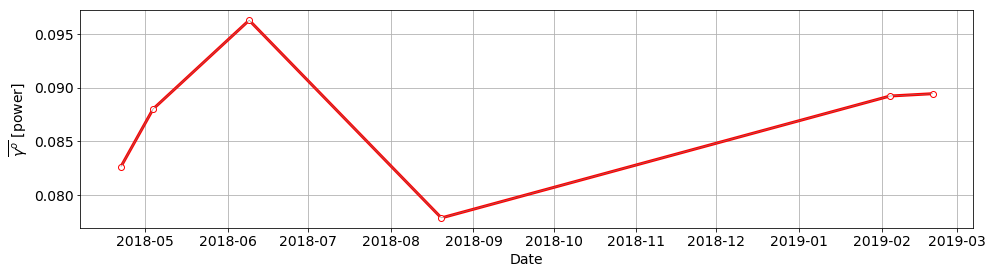

In [43]:
# 4. Now let's plot the time series of means
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(111)
window_length = len(rs_means_pwr)-1
if window_length % 2 == 0:
    window_length -= 1
polyorder = window_length - 1
yhat = scipy.signal.savgol_filter(rs_means_pwr, window_length, polyorder) 
ax1.plot(tindex,yhat, color='red', marker='o', markerfacecolor='white', linewidth=3, markersize=6)
ax1.plot(tindex,rs_means_pwr, color='gray', linewidth=0.5)
plt.grid()
ax1.set_xlabel('Date')
ax1.set_ylabel('$\overline{\gamma^o}$ [power]')
plt.savefig('RCSoverTime.png', dpi=300, transparent='true')

<br>
<hr>
<font face="Calibri" size="4"> <b> 3.6 Calculate Coefficient of Variance </b> </font>

<font face="Calibri" size="3"> The coefficient of variance describes how much the $\sigma_{0}$ or $\gamma_{0}$ measurements in a pixel vary over time. Hence, the coefficient of variance can indicate different vegetation cover and soil moisture regimes in your area.</font> 

In [44]:
test = np.var(rasterstack,0)
mtest = np.mean(rasterstack[rasterstack.nonzero()],0)
coeffvar = test/(mtest+0.001)

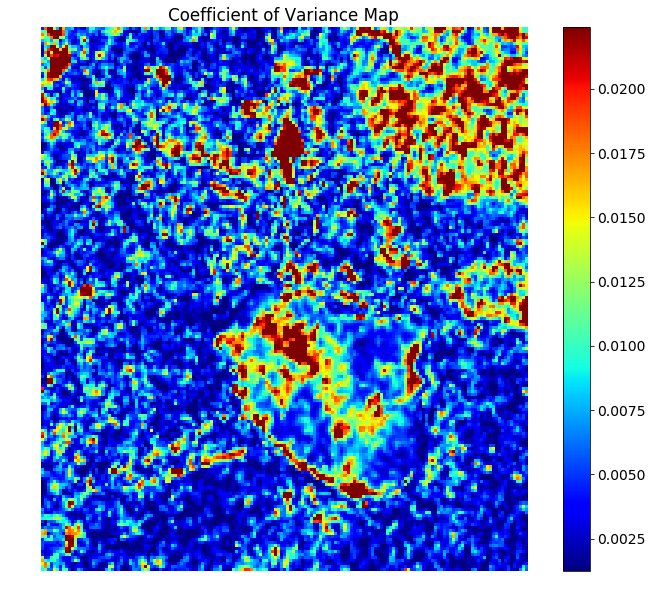

In [45]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(13, 10))
ax = fig.add_subplot(111)
ax.axis('off')
vmin = np.percentile(coeffvar.flatten(), 5)
vmax = np.percentile(coeffvar.flatten(), 95)
ax.set_title('Coefficient of Variance Map')

im = ax.imshow(coeffvar, cmap='jet', vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=ax)
plt.savefig('Coeffvar.png', dpi=300, transparent='true')

<br>
<hr>
<font face="Calibri" size="4"> <b> 3.7 Threshold Coefficient of Variance Map </b> </font>

<font face="Calibri" size="3"> This is an example how to threshold the derived coefficient of variance map. This can be useful, e.g., to detect areas of active agriculture.</font> 

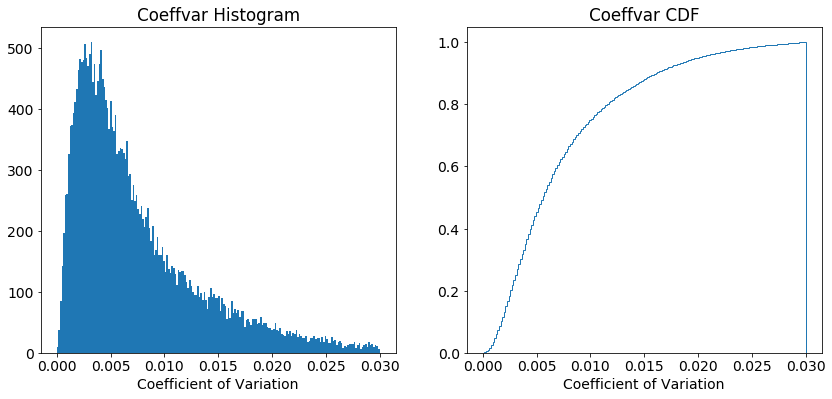

In [46]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(14, 6)) # Initialize figure with a size
ax1 = fig.add_subplot(121)  # 121 determines: 2 rows, 2 plots, first plot
ax2 = fig.add_subplot(122)
# Second plot: Histogram
# IMPORTANT: To get a histogram, we first need to *flatten* 
# the two-dimensional image into a one-dimensional vector.
h = ax1.hist(coeffvar.flatten(), bins=200, range=(0, 0.03))
ax1.xaxis.set_label_text('Coefficient of Variation')
ax1.set_title('Coeffvar Histogram')
plt.grid()
n, bins, patches = ax2.hist(coeffvar.flatten(), bins=200, range=(0, 0.03), cumulative='True', density='True', histtype='step', label='Empirical')
ax2.xaxis.set_label_text('Coefficient of Variation')
ax2.set_title('Coeffvar CDF')
plt.grid()

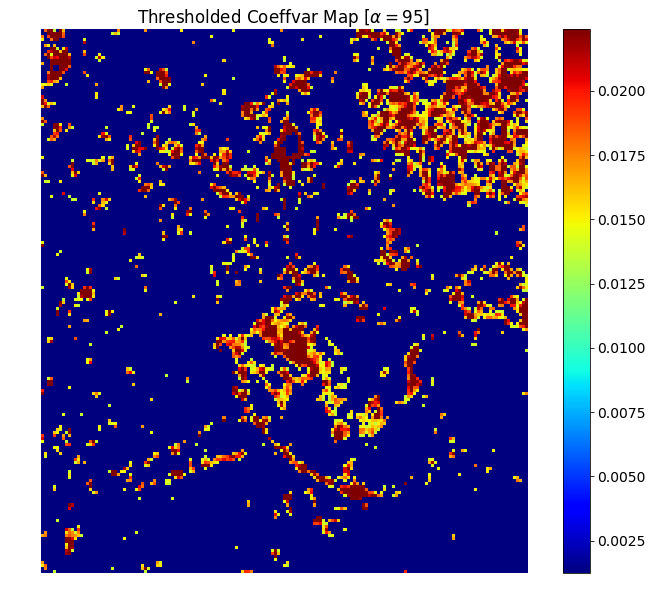

In [47]:
plt.rcParams.update({'font.size': 14})
outind = np.where(n > 0.85)
threshind = np.min(outind)
thresh = bins[threshind]
coeffvarthresh = np.copy(coeffvar)
coeffvarthresh[coeffvarthresh < thresh] = 0
coeffvarthresh[coeffvarthresh > 0.1] = 0
fig = plt.figure(figsize=(13, 10))
ax = fig.add_subplot(111)
ax.axis('off')
vmin = np.percentile(coeffvar.flatten(), 5)
vmax = np.percentile(coeffvar.flatten(), 95)
ax.set_title(r'Thresholded Coeffvar Map [$\alpha=95%$]')

im = ax.imshow(coeffvarthresh, cmap='jet', vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=ax)
plt.savefig('Coeffvarthresh.png', dpi=300, transparent='true')

<font face="Calibri" size="2"> <i>GEOS 657 Microwave Remote Sensing - Version 1.0 - March 2019 </i>
</font>